<a href="https://colab.research.google.com/github/sumedhekaru/Analysing-Student-Reviews/blob/master/CEnergy_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consumer Energy Project
## Problem Description:

Consumer Energy (CE) provide electricity and gas to close to 7 million Michiganders with ~6000 MW of energy generating capacity. With a 70 k miles of electric network and a 27 k miles of gas line network, it is not unusual that service disruptions occur due to various reasons such as weather-related events.

When there is a disruption to service, CE customers can report outage [here.](https://www.consumersenergy.com/outages/outage-center). In such situations, CE is committed to solving the problem as soon as possible. While CE doing their best to resolve the outages, customers want to know approximate service Restore Time (Restore Time, RT for short). 

CE will use multiple tools to estimate restore time ([Restore time FAQ](https://https://www.consumersenergy.com/outages/etr-faq)). Machine Learning is leveraged to provide the best estimate of restore time using previous known events and time it took to restore the service. We capture data including location, weather, type of the disruption, number of customers, etc. Then we use this data to train a machine-learning algorithm to provide the best estimates for restore time.

While CE is committed to restoring service within this initial best-estimated restore time, customers will be updated continuously if there are any changes to this restore time.

## Data:
Data were captured for previous restore times and can be temporarily accessed via my google drive link.

Info and describe methods are used to get a basic understanding of the data. Data didn't have any null values. 

'Type' is a categorical column and other data columns are continues. The range of all columns is in the same order. Therefore no normalization or standardisation is required. Let's define the target column and feature columns.

**Target column**: RestoreTime

**Feature columns**: Apples,  Lions,  Bears,  Tigers, Oranges,  Grapes, Type, Area, Strawberries, Length

*Note:* Target column has negative values, this could be due to data entry error or standardization effect. Contact business owners to learn about the logic behind restore time data collection. For now, continue working on the models.

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


In [2]:
data_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTk0c774KgqtV8EXsTM2nEBr5_twjY2NoUz4ArBBPqaBzz8KsHY2i7V5gwKZpU5_XDf8fwPS1clSYHe/pub?output=csv'
df = pd.read_csv(data_url)
df

,Apples,Lions,Bears,Tigers,Oranges,Grapes,Type,Area,Strawberries,Length,RestoreTime
0,49,6,20,4,7,36,1,19,3,49,32.620000
1,35,46,16,8,46,11,0,10,6,25,204.062500
2,9,25,14,16,27,32,0,24,48,19,110.857143
3,44,49,9,13,16,44,0,39,7,10,108.666667
4,48,16,11,11,43,34,0,9,10,26,138.272727
...,...,...,...,...,...,...,...,...,...,...,...
995,23,20,19,6,50,41,0,14,36,4,51.473684
996,3,42,20,15,36,46,0,7,13,48,296.900000
997,29,36,18,3,4,47,0,45,35,13,27.833333
998,3,38,11,10,26,11,1,31,27,46,56.600000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Apples        1000 non-null   int64  
 1   Lions         1000 non-null   int64  
 2   Bears         1000 non-null   int64  
 3   Tigers        1000 non-null   int64  
 4   Oranges       1000 non-null   int64  
 5   Grapes        1000 non-null   int64  
 6   Type          1000 non-null   int64  
 7   Area          1000 non-null   int64  
 8   Strawberries  1000 non-null   int64  
 9   Length        1000 non-null   int64  
 10  RestoreTime   1000 non-null   float64
dtypes: float64(1), int64(10)
memory usage: 86.1 KB


In [4]:
df.describe()

,Apples,Lions,Bears,Tigers,Oranges,Grapes,Type,Area,Strawberries,Length,RestoreTime
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,25.732000,25.80700,10.361000,10.547000,25.373000,25.676000,0.499000,24.498000,25.089000,24.916000,79.837517
std,14.523399,14.37903,5.606256,5.813053,14.669256,14.703987,0.500249,14.536964,14.254412,14.565064,76.119021
min,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,-85.571429
25%,13.000000,13.00000,6.000000,5.000000,12.750000,13.000000,0.000000,12.000000,13.000000,12.000000,27.269286
50%,27.000000,26.00000,10.000000,10.000000,26.000000,25.000000,0.000000,24.000000,25.000000,24.000000,53.345000
75%,38.000000,39.00000,15.000000,16.000000,38.000000,39.000000,1.000000,37.000000,37.000000,38.000000,126.406250
max,50.000000,50.00000,20.000000,20.000000,50.000000,50.000000,1.000000,50.000000,50.000000,50.000000,421.000000


### Data Corelation:
According to the statistics output, it looks like some of the variable distributions are similar (Eg. Apples and Lions). We need to make sure those are not highly correlated. If the feature columns are highly correlated, we can drop some of the columns.

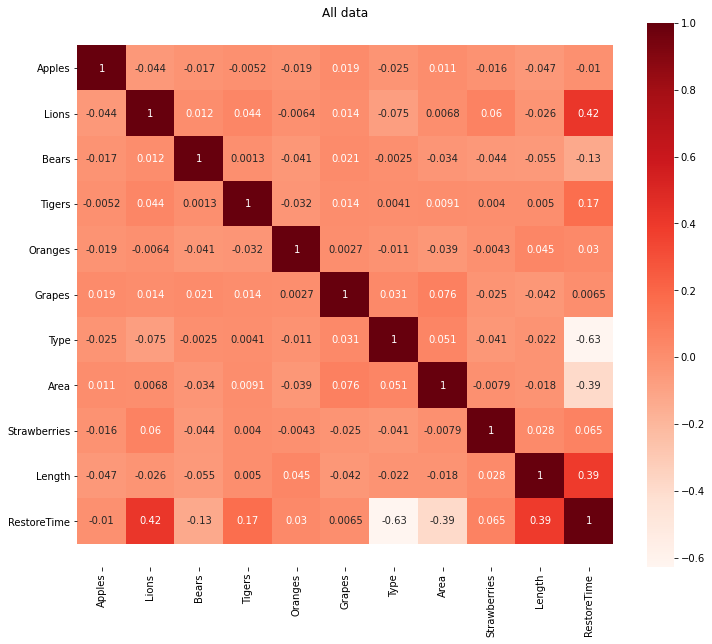

In [5]:
def draw_corr_plot(df,title):
    df_corr = df.corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(df_corr, annot=True,cmap=plt.cm.Reds)

    # Workarround for top and bottom ylim not showing properly
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    plt.title(title)
    plt.show()
    
draw_corr_plot(df,'All data')

According to the above test, none of the feature columns is correlated with another feature column as the Pearson correlation is smaller. Therefore, we can't drop any features based on that.

On the other hand, there is no strong correlation between the target column and any of the feature columns. There is a chance that we can drop features like Grapes as they could be simply noise. Further evaluations are needed.

Let's do a quick pair plot to recognize distributions of values.

<Figure size 432x288 with 0 Axes>

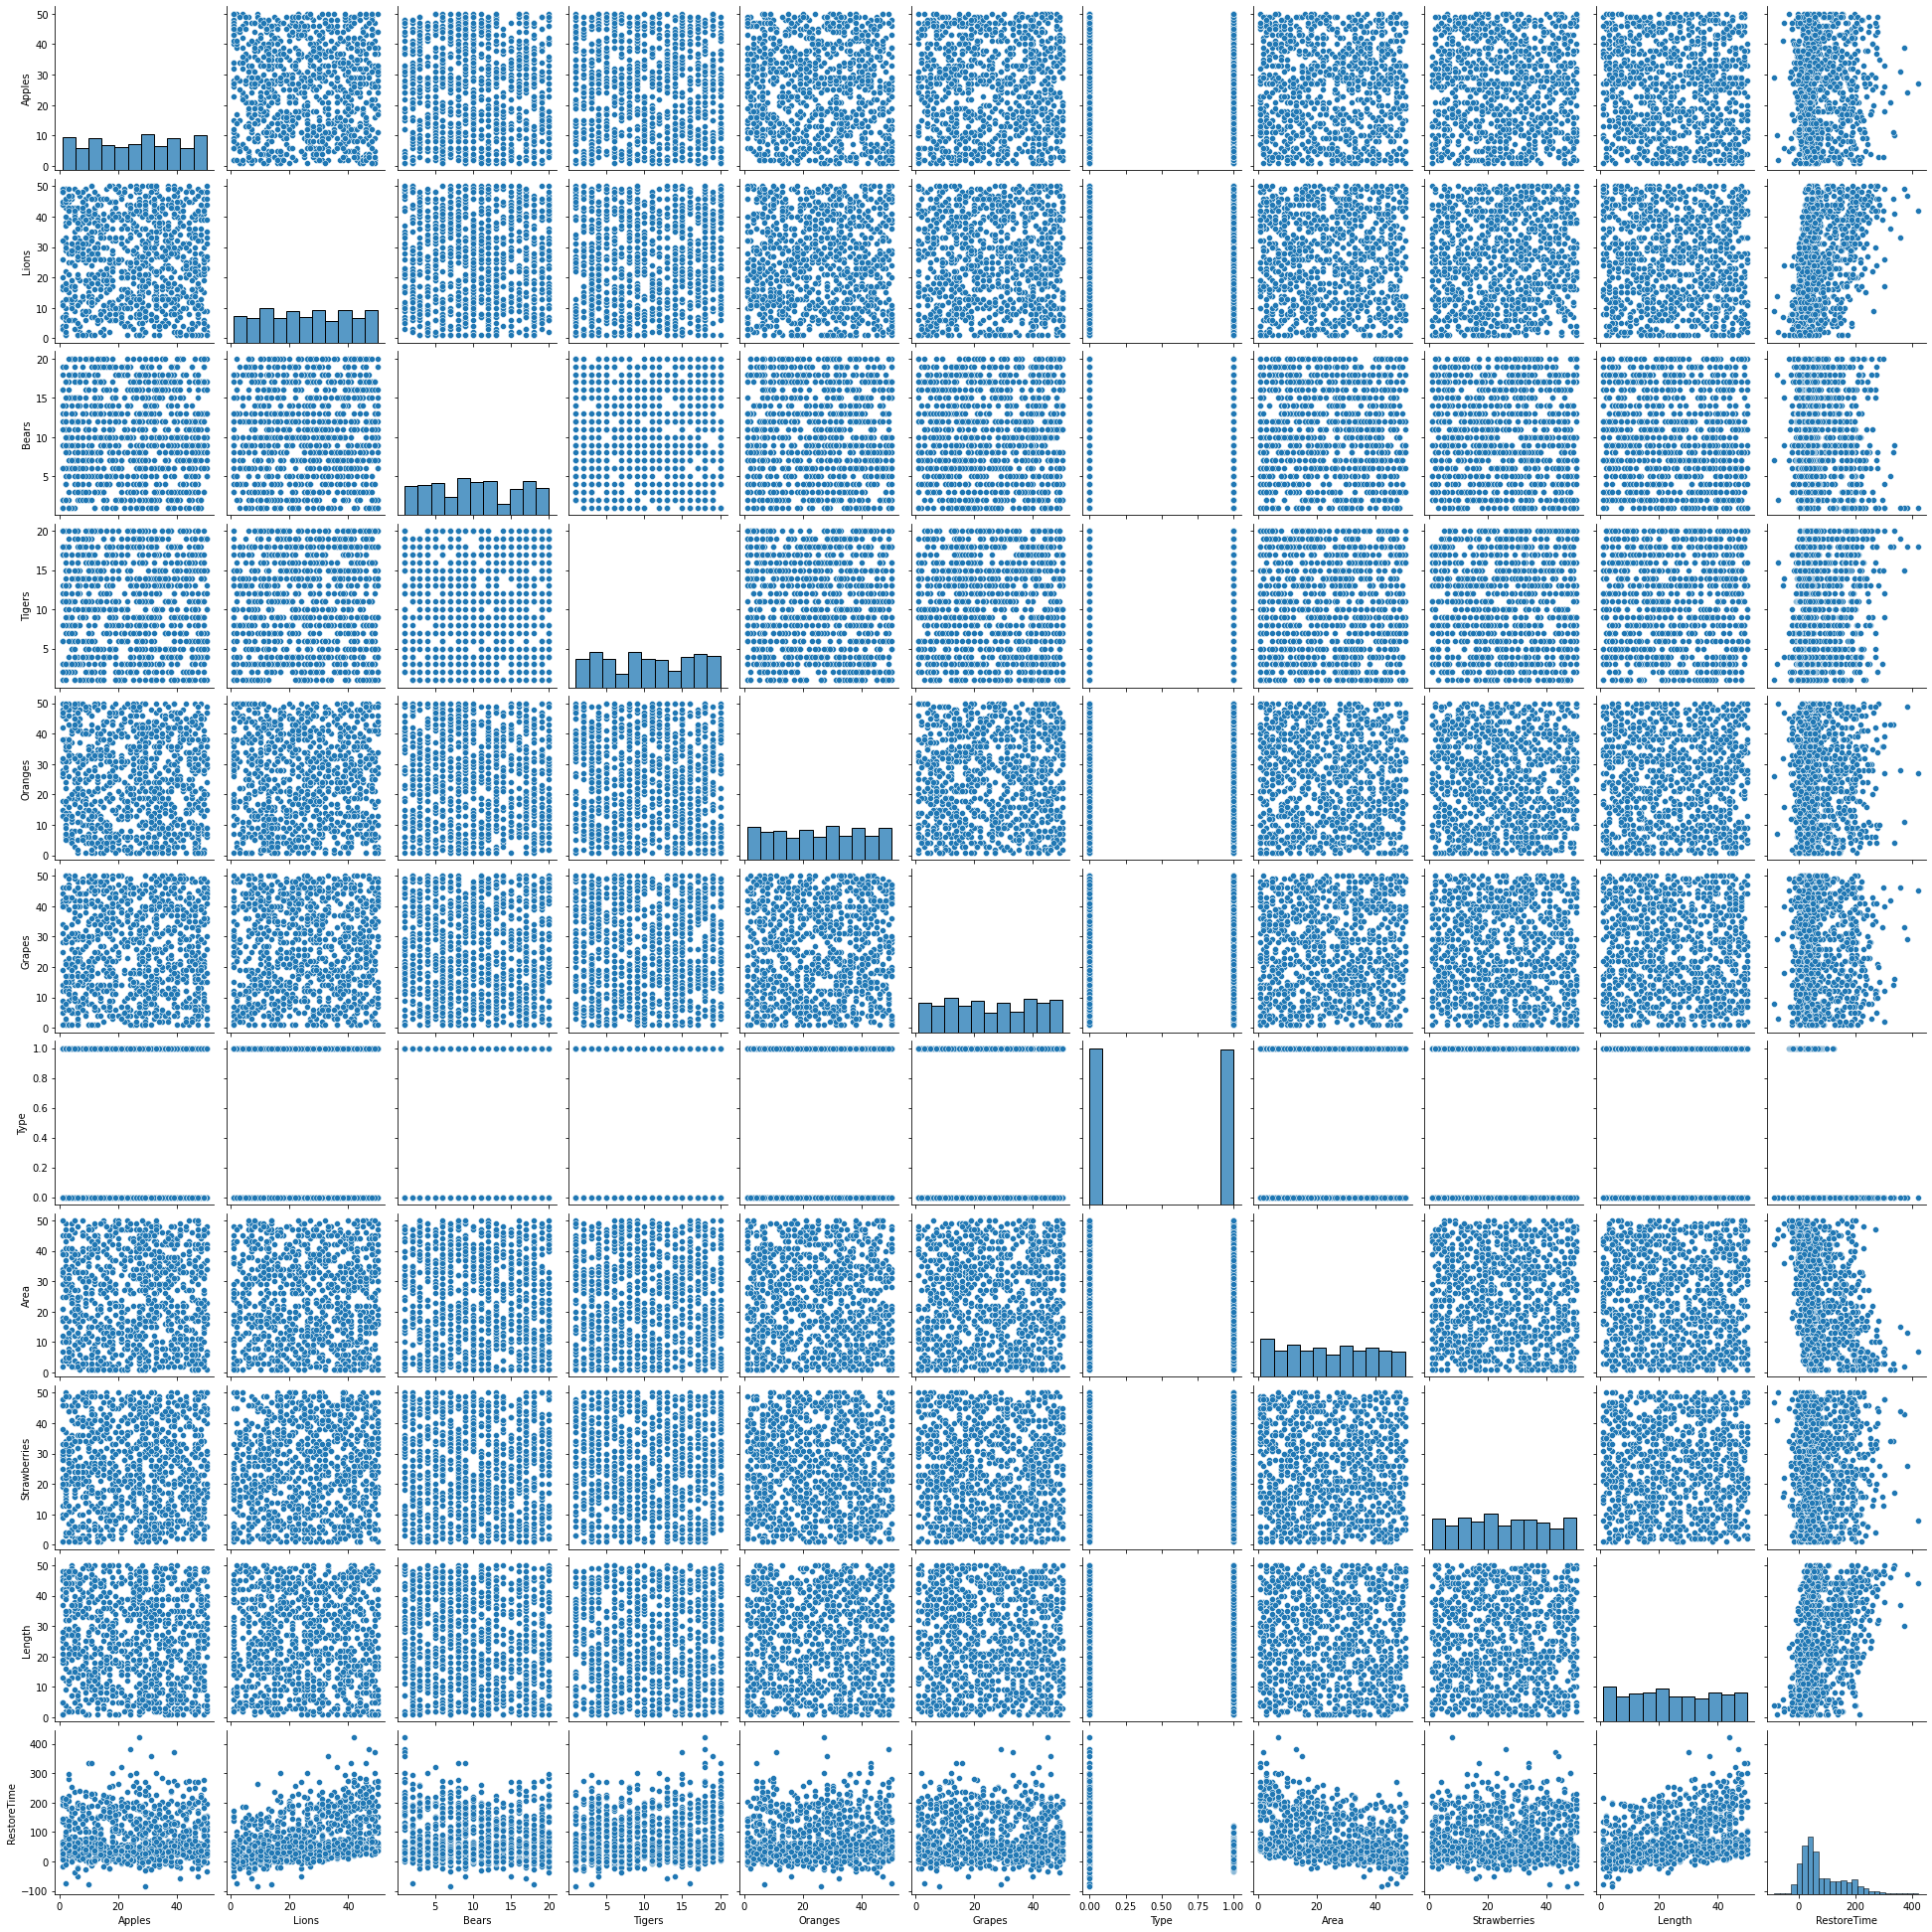

In [6]:
plt.figure()
sns.pairplot(df)
plt.show()

Above pair-plots confirmed that there is no strong correlation between features (showing dots all over the graph).

There may be a chance that we can eliminate some of the columns based on model performances. So far, I am not dropping any columns based on just this information.

### Data Correlation between target variable and features
Let's have a visual look for a target variable and feature columns

According to the following plots, there is a good chance that some of the columns could provide no value to the model, but we will figure this out when we do actual modelling.

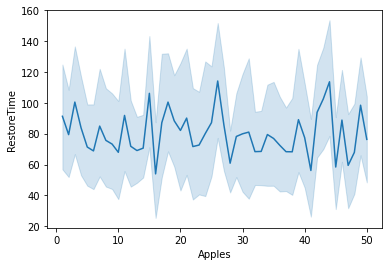

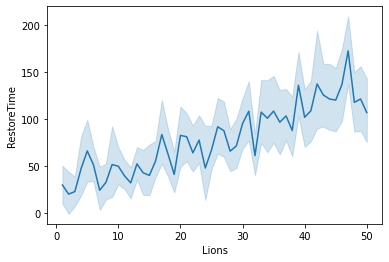

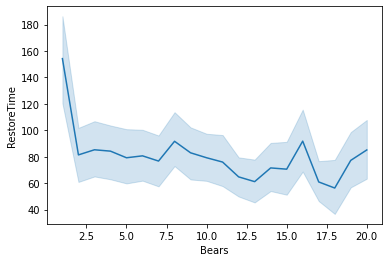

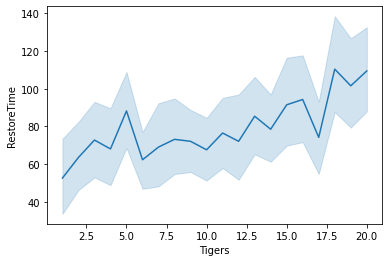

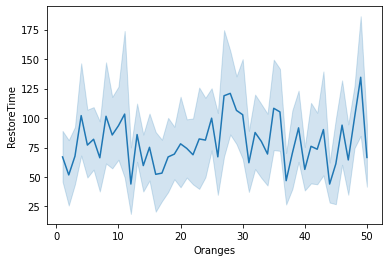

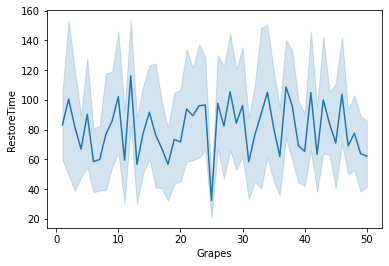

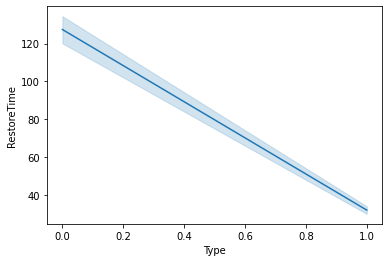

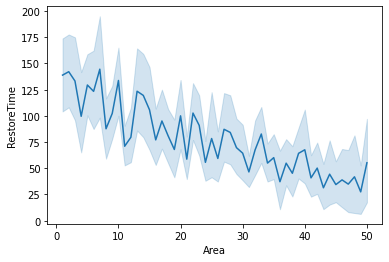

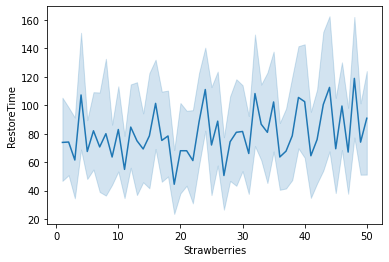

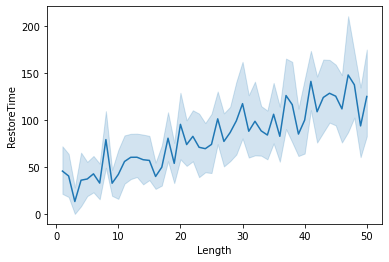

In [7]:
target = 'RestoreTime'
columns = df.columns[df.columns != target]

for x in columns:
    plt.figure()
    sns.lineplot(data=df, x=x,y=target)

## Feature selection and Model selection
### Feature selection (univarient feature selection)
We will try to find out a variance of the variables and order them by highest to the least. Then we will build the model using an exclusion method which exclude each least-important feature one by one and test the performance. We will use LinearRegression as the baseline model as it is simple and fast.

In [8]:
# Test Train split
y = df[target]
X = df.drop(columns=[target])

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (670, 10) (670,)
Test (330, 10) (330,)


Type            0.328709
Length          0.150593
Lions           0.144400
Area            0.136700
Strawberries    0.037945
Oranges         0.009611
Tigers          0.002569
Grapes          0.000000
Bears           0.000000
Apples          0.000000
dtype: float64

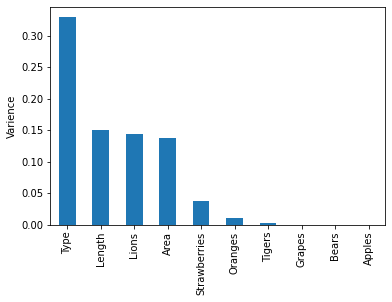

In [9]:
# Find the most important columns in order
mir = mutual_info_regression(X_train,y_train)
mir = pd.Series(mir)
mir.index = X_train.columns
mir.sort_values(ascending=False,inplace=True)
mir.plot.bar()
plt.ylabel('Varience')
mir

The plan is to create a baseline model with all the variables except Grapes, Bears, and Apples as they have zero variance. 

Further, other feature variables can be removed starting from the least important feature which is Tigers.

### Model selection

Let's start with the easiest and straight forward one, linear regression.

In [10]:
# Create a method to get a few scores and vizual verification.
def get_scores(model,X,y,type='None'):
    y_p = model.predict(X)
    print(f'R2_score \t\t: {metrics.r2_score(y, y_p):0.2f}')
    print(f'Mean Absolute Error\t: {metrics.mean_absolute_error(y, y_p):0.2f}')
    #print(f'Mean Squared Error: {metrics.mean_squared_error(y, y_p):0.2f}')
    print(f'Root Mean Squared Error\t: {np.sqrt(metrics.mean_squared_error(y, y_p)):0.2f}')
    
    
    if type is not None:
        print(type)
    
    plt.figure(figsize=(6,6))
    plt.scatter(y,y_p,facecolors='none', edgecolors='r')
    plt.plot( [-100,400],[-100,400] )
    plt.title(f'Type = {type}')
    plt.xlabel('Target')
    plt.ylabel('Modeled')
    
    return y_p

#### Linear Regression
After running the model, 
1. It is evident that red dots are significantly away from the blue line (if the red dots are all on the blue line, it is a perfect fit). So linear regression is not a good fit.
1. It looks like, there are two trends of data within the data set, our current model can't distinguish when there are multiple linear relationships.
1. I do like the fact that all the scoring methods for both train and test are about the same. At least, there may be less overfitting.

R2_score 		: 0.83
Mean Absolute Error	: 24.57
Root Mean Squared Error	: 31.50
Train
R2_score 		: 0.82
Mean Absolute Error	: 24.97
Root Mean Squared Error	: 31.85
Test


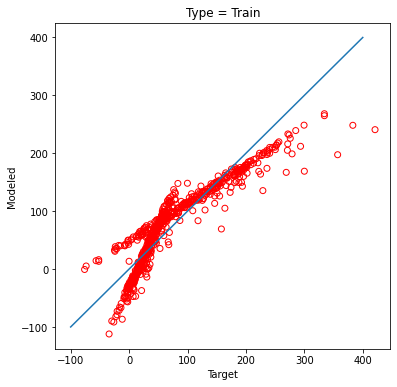

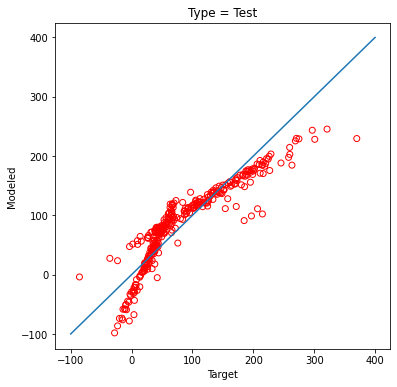

In [11]:
# Get first 7 features (last 3 features dropped as they have zero varience.)
sel = SelectKBest(mutual_info_regression, k = 7).fit(X_train,y_train)
columns = X_train.columns[sel.get_support()]

# Linear regression
model = LinearRegression()
model.fit(X_train[columns], y_train)
get_scores(model,X_train[columns],y_train, type='Train')
y_pred = get_scores(model,X_test[columns],y_test,type='Test')

#### Random Forest Regressor
Since the data seems to have a dual linear relationship, RandomForestRegressor should be able to handle it. 

After running it, it was clear that,
1. RandomForestClassifier did a much better job than LinearRegressor. 
1. All train, test accuracies improved.
1. I didn't like the fact that accuracies are significantly different from train and test sets. This is evident from the visual representation as well.
1. There is a bit of over-fitting occurring. Changing several hyperparameters did not balance this behaviour. But I would still consider this model is better than the Linear regression as the test set accuracy increased.
1. I also tried Extra Trees Regressor (later commented out), which also did a great job for the test set, but not for the training set, as expected.

R2_score 		: 0.99
Mean Absolute Error	: 5.21
Root Mean Squared Error	: 8.61
Train
R2_score 		: 0.90
Mean Absolute Error	: 15.27
Root Mean Squared Error	: 23.37
Test


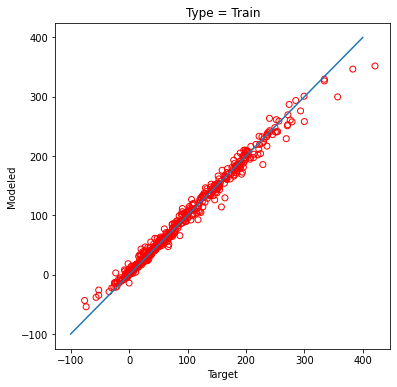

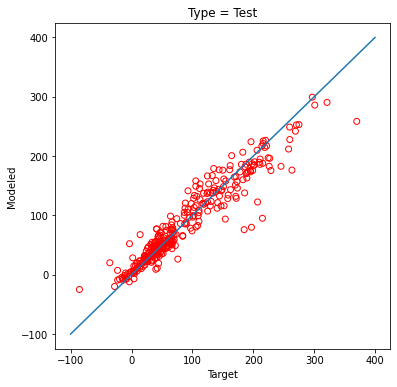

In [12]:
model = RandomForestRegressor(n_estimators=100, random_state=0,criterion='mae',max_depth=100)
#model = ExtraTreesRegressor(n_estimators=100, random_state=100,criterion='mse',max_depth=9)
model.fit(X_train[columns], y_train)
get_scores(model,X_train[columns],y_train, type='Train')
y_pred = get_scores(model,X_test[columns],y_test,type='Test')

#### Custom ensemble method

It is noticeable that there are two linear relationships from the first attempt. I was wondering if we can create an ensemble method that creates these two lines. So plan here to create a custom ensemble method that can handle two sets of data separately. Further, research indicated that these two sets are created from type=0 and type=1 kind. 

After running the custom ensemble method
1. Train accuracy dropped a bit.
1. Test accuracy improved.
1. Test train accuracies are balanced, therefore there is less overfitting.
1. There are some underestimated values that need to be addressed later.

In [13]:
# create custom linear ensemble method
class custom_ensemble_lr():
    # Quick and derty way to create a super custom linear ensemble.
    # Need to handle various errors.
    # Need to generalize if needed.

    def __init__(self):
        pass
    
    def fit(self,X_train, y_train,fit_intercept=True,normalize=False):
        # Asuume enough samples are available for both types
        ind_0 = X_train.Type == 0
        X_train_0 = X_train[ind_0]
        y_train_0 = y_train[ind_0]
        
        ind_1 = X_train.Type == 1
        X_train_1 = X_train[ind_1]
        y_train_1 = y_train[ind_1]
                
        self.model_0 = LinearRegression(fit_intercept=fit_intercept,normalize=normalize)
        #self.model_0 = RandomForestRegressor(n_estimators=100, random_state=0,criterion='mae',max_depth=100)
        self.model_0.fit(X_train_0,y_train_0)
        
        self.model_1 = LinearRegression(fit_intercept=fit_intercept,normalize=normalize)
        #self.model_1 = RandomForestRegressor(n_estimators=100, random_state=0,criterion='mae',max_depth=100)
        self.model_1.fit(X_train_1,y_train_1)

        return self
    
    def predict(self,X):
        #print(X)
        ind0 = X.Type == 0
        y_p_0 = self.model_0.predict(X[ind0])
        
        ind1 = X.Type == 1
        y_p_1 = self.model_1.predict(X[ind1])
        
        Y = X.copy()
        Y.loc[ind0,'pred'] = y_p_0
        Y.loc[ind1,'pred'] = y_p_1
        #print(Y)
        return Y['pred']


R2_score 		: 0.96
Mean Absolute Error	: 7.52
Root Mean Squared Error	: 14.87
Train
R2_score 		: 0.95
Mean Absolute Error	: 8.21
Root Mean Squared Error	: 16.94
Test


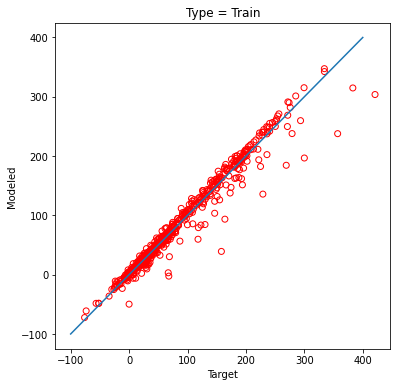

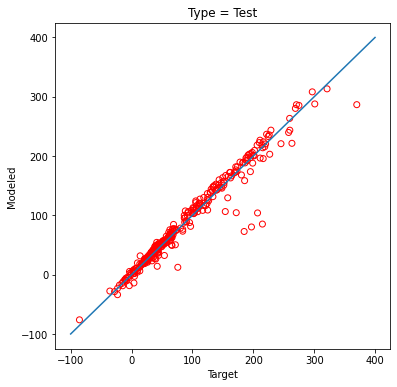

In [14]:
# Evaluate the custom ensemble.
model = custom_ensemble_lr()
model.fit(X_train[columns], y_train,fit_intercept=True,normalize=False)
get_scores(model,X_train[columns],y_train, type='Train')
y_pred = get_scores(model,X_test[columns],y_test,type='Test')

## Final Model training and prediction.

At the end, based on the model accuracy and the balance between accuracies of the test and train sets, I decided that the ensemble method performed the best. There are some underestimated values that needed to be addressed. This could be simply some outliers in data but need further research to answer.

Let's train the final model using the whole data set, and start predicting the restore time for unseen data from the model.

One final fiddle around k also revealed that k = 7 gave me the best model.

R2_score 		: 0.96
Mean Absolute Error	: 7.77
Root Mean Squared Error	: 15.56
Train


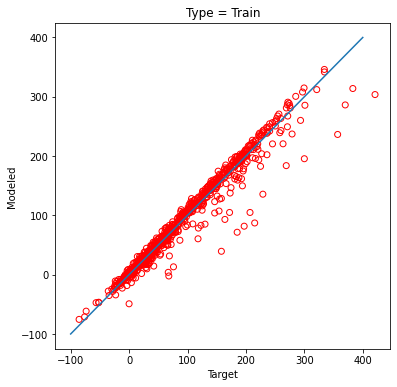

In [15]:
# Train the model using all data
sel = SelectKBest(mutual_info_regression, k = 7).fit(X_train,y_train)
columns = X_train.columns[sel.get_support()]


model = custom_ensemble_lr()
model.fit(X[columns], y,fit_intercept=True,normalize=False)
y_hat = get_scores(model,X[columns],y, type='Train')

In [16]:
# Predict the un seen data
X_unseen = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSwHXbecr9QgtPOVIw5OJryZ2dGm4e-LoPrtWarGbofwn__W9Cmdp0RKqOANHEwqOYXX1cy9Q_Pmqdo/pub?output=csv')
X_unseen

,Apples,Lions,Bears,Tigers,Oranges,Grapes,Type,Area,Strawberries,Length
0,48,1,16,6,21,40,0,38,40,33
1,27,41,11,20,17,2,1,18,13,11
2,3,41,6,17,16,43,1,7,22,39
3,26,9,7,12,37,4,0,8,14,17
4,40,19,14,2,43,3,1,6,30,3


In [17]:
# Predict restore times and get prediction intervals
def get_prediction_intervals(y_unseen,y_test, y_pred, X_unseen):
    
    # Standard deviation betweeen modeled and observed
    STD = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    
    # 95 % significance level for prdiction = 1.96 STD
    interval = 1.96 * STD
    
    # Overall lower and upper boundaries. (Sample based method must be developed)
    lower = round(y_unseen - interval, 2)
    upper = round(y_unseen + interval, 2)
    
    #print(lower)
    df = X_unseen.copy()
    df['PredictedRestorTime'] = round(y_unseen,2)
    df['Lower95pecentile_PRT'] = lower
    df['Upper95pecentile_PRT'] = upper
    df['interval'] = interval
   
    return df, interval

y_unseen = model.predict(X_unseen[columns])
df_unseen,interval = get_prediction_intervals(y_unseen,y,y_hat, X_unseen)
df_unseen

,Apples,Lions,Bears,Tigers,Oranges,Grapes,Type,Area,Strawberries,Length,PredictedRestorTime,Lower95pecentile_PRT,Upper95pecentile_PRT,interval
0,48,1,16,6,21,40,0,38,40,33,18.59,-11.91,49.09,30.503772
1,27,41,11,20,17,2,1,18,13,11,49.91,19.41,80.41,30.503772
2,3,41,6,17,16,43,1,7,22,39,81.86,51.35,112.36,30.503772
3,26,9,7,12,37,4,0,8,14,17,97.81,67.31,128.31,30.503772
4,40,19,14,2,43,3,1,6,30,3,17.42,-13.09,47.92,30.503772


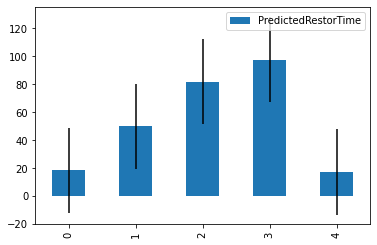

In [18]:
# Vizual represenatation of final values
df_unseen.plot(kind = 'bar', y = 'PredictedRestorTime',yerr='interval')

Above plot represent the predicted restore time for the 5 points that are unseen by the model before. The added vertical line represents the 95th overall confident range. These results were manually verified that they are close to the events similar to those in the data.

# Discussion:

A problem was presented to use machine learning algorithms to predict Restore Time. 
* While, 10 different input features are investigated (Apples, Lions, Bears, Tigers, Oranges, Grapes, Type, Area, Strawberries, and Length), 3 columns were dropped due to low impact for the prediction (Grapes, Bears, Apples).
* Various algorithms were tried, but we ended up using a custom-written ensemble model that uses two separate linear regressors underneath. This model gave the best balance between accuracy vs overfitting.
* 5 data points unseen by the model was modelled and manually verified to see if they are in close with the similar events.

## Improvements:
* While the accuracy is pretty good, there are a significant number of underestimated values. Mathematically, the residuals of these over and under-estimated values are balanced. However, further research needed to reduce this effect. Some of the suggestions could be 
  * Choosing a different set of features among the seven features chosen.
  * Improving ensemble model further customize to the problem.
  * Look for outliers in the data in each feature as well as the target.

* Uncertainty estimations are macro to the model. Micro uncertainty estimations are much suitable for final deployment.

## Reference:
1. [Scikit Learn Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
1. [Scikit Learn Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
1. Scikit Learn Extra Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)
1. [Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
1. [Prediction Intervals in Linear Regression](https://towardsdatascience.com/prediction-intervals-in-linear-regression-2ea14d419981)